In [1]:
import math

%matplotlib inline
from matplotlib import pyplot as plt

import gpytorch
import torch

import pyro
from pyro.infer.mcmc import NUTS, MCMC
pyro.set_rng_seed(0)

In [2]:
train_x = torch.linspace(0, 2, 7)
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.1

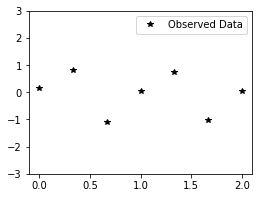

In [3]:
f, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
ax.set_ylim([-3, 3])
ax.legend(['Observed Data']);

In [4]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, batch_shape=torch.Size()):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(
            batch_shape=batch_shape,
        )
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(batch_shape=batch_shape),
            batch_shape=batch_shape
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood, batch_shape=torch.Size())

# Here - we'll do some initializtion of the two period lengths
# so that our optimization finds two different modes
model.covar_module.base_kernel.initialize(period_length=torch.tensor(0.5))

PeriodicKernel(
  (raw_lengthscale_constraint): Positive()
  (raw_period_length_constraint): Positive()
)

In [6]:
model.train()
likelihood.train()
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [7]:
def potential_fn(params):
    model._load_raw_parameters(**params)
    output = model(train_x)
    return -mll(output, train_y).sum()

init_params = {k: v for k, v in model.state_dict().items()}

In [8]:
hmc_kernel = NUTS(model=None, potential_fn=potential_fn, jit_compile=False,
                  ignore_jit_warnings=True)
hmc_kernel.initial_params = init_params
mcmc_run = MCMC(hmc_kernel, num_samples=1000, warmup_steps=500).run()

Warmup:   1%|▏         | 20/1500 [00:40<1:15:57,  3.08s/it, step size=6.70e-02, acc. rate=0.950]


RuntimeError: cholesky_cpu: U(7,7) is zero, singular U.